Pythonによる機械学習モデル構築の練習。

複数の手法によるテキスト分類精度を確認します。処理の流れは以下です。

1. データロード
2. 単語区切り、日本語（Mecab)
3. 単語頻度によるベクトルを作る
4. 交差検定用のデータ分割

以下は手法ごとに回していきます。

5. 交差検定データごとに、最善のパラメータ探索
6. confusion matrix 表示
7. PR曲線を描きます。

各手法でのRecall100時のPrecisionはいくらかな？を比較がしたい。

In [3]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3
!pip install unidic-lite
!python -m unidic download
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.12)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.19)
xz-utils is already installed at the requested version (5.2.2-1.3ubuntu0.1)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import json

# json_open = open('./sample_data/sample2.json', 'r')
json_open = open('/content/drive/My Drive/ldcc.json', 'r')
json_load = json.load(json_open)  

print(len(json_load))

7376


In [4]:
import MeCab
from tqdm import tqdm, tqdm_pandas, tqdm_notebook
from tqdm.notebook import tqdm_notebook

import numpy as np
import pandas as pd
from pandas import json_normalize

df = json_normalize(json_load) #Results contain the required data
df.dropna(inplace=True)

def get_wakati_text(text) -> None:
  tagger = MeCab.Tagger("-Owakati")
  wakati_text = tagger.parse(text).strip()
  return wakati_text

tqdm_notebook.pandas(desc='mecab progress: ')
df['wakati_text'] = df.text.progress_apply(get_wakati_text)

def convert_to_num_label(label):
  if label == 'dokujo-tsushin':
    return 1
  else:
    return -1

tqdm_notebook.pandas(desc='label change progress: ')
df['label'] = df.cls.progress_apply(convert_to_num_label)
print(df['label'])

mecab progress:   0%|          | 0/7376 [00:00<?, ?it/s]

label change progress:   0%|          | 0/7376 [00:00<?, ?it/s]

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
7371   -1
7372   -1
7373   -1
7374   -1
7375   -1
Name: label, Length: 7376, dtype: int64


In [7]:
s = df['label']
print([(s == -1).sum(), (s == 1).sum()])

[6505, 871]


# 学習データと正解ラベルの配列を作成する

Xとyである。

In [17]:
# df.head()
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# y = df.cls.values
y = df.label.values
vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b', min_df=40, max_df=1000)
X = vectorizer.fit_transform(df.wakati_text.values)
X = X.toarray()
X.shape


(7376, 5494)

# SVM（線形カーネル）とlogistic Regression編

処理手順

1. 交差検定のデータを作る
2. Grid Searchでベストパラメータを作成
3. ベストパラメータでPR曲線を描く

独女通信を絶対見つけるマシーンでPが高いのはSVMとLRのどっちなんだい？

**線形モデルの力を見せてくれ！!**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................C=1, kernel=linear; total time= 1.0min
[CV] END .................................C=1, kernel=linear; total time= 1.2min
[CV] END .................................C=1, kernel=linear; total time= 1.1min
[CV] END .................................C=1, kernel=linear; total time= 1.1min
[CV] END .................................C=1, kernel=linear; total time= 1.0min
{'mean_fit_time': array([62.9678112]),
 'mean_score_time': array([1.98650699]),
 'mean_test_score': array([0.96494293]),
 'param_C': masked_array(data=[1],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_kernel': masked_array(data=['linear'],
             mask=[False],
       fill_value='?',
            dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.96321394]),
 'split1_test_score': array([0.96418199]),
 'spl

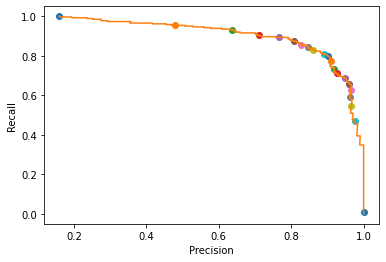

[-1  1]
              precision    recall  f1-score   support

          -1       0.98      0.98      0.98      1952
           1       0.86      0.83      0.85       261

    accuracy                           0.96      2213
   macro avg       0.92      0.91      0.91      2213
weighted avg       0.96      0.96      0.96      2213

 ----- list1 -----
              precision    recall  f1-score   support

          -1       1.00      0.74      0.85      1952
           1       0.33      0.97      0.49       261

    accuracy                           0.77      2213
   macro avg       0.66      0.86      0.67      2213
weighted avg       0.92      0.77      0.81      2213

[[1439  513]
 [   7  254]]



In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pprint as pp
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

def show_confusion_matrix(svmclf, X_test, y_test, params):
  y_pred = svmclf.predict(X_test) 
  y_values = svmclf.decision_function(X_test)
  # ad-hoc
  # class 0なら、minus方面、class 1なら plus方面
  cls_idx_dict = {}
  threshhold = params['threshhold']
  print(svmclf.classes_)
  for idx, key in enumerate(svmclf.classes_):
    # cls_idx_dict[key] = idx
    cls_idx_dict[idx] = key

  list1 = []
  # {-1, 1}
  for value in y_values:
      if value < threshhold:
        cls = cls_idx_dict[0]
        list1.append(cls)
      else:
        cls = cls_idx_dict[1]
        list1.append(cls)
  
  print(classification_report(y_test, y_pred))
  print(" ----- list1 -----")
  print(classification_report(y_test, list1))
  cm = metrics.confusion_matrix(y_test, list1)
  print(cm)
  print()

def traverse_data_split1(key, X, y):
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
    for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
      print(f'Start: fold {i+1}')
      X_train, y_train = X[train_index, :], y[train_index]
      X_valid, y_valid = X[valid_index, :], y[valid_index]

      tuned_parameters = [
        {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
      ]
      gogo_grid_search_SVM(X_train, y_train, X_valid, y_valid, tuned_parameters)

def traverse_data_split(key, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    tuned_parameters = [
           #{'C': [1, 10, 100, 1000], 'kernel': ['linear']},  
           {'C': [1], 'kernel': ['linear']},
    ]
    gogo_grid_search_SVM(X_train, y_train, X_test, y_test, tuned_parameters)

def gogo_grid_search_SVM(X_train, y_train, X_test, y_test, tuned_parameters):
  score = 'recall'
  #clf = GridSearchCV( 
  #    SVC(), # 識別器
  #    tuned_parameters, # 最適化したいパラメータセット 
  #    cv=5, # 交差検定の回数
  #    scoring='%s_weighted' % score ) 
  clf = GridSearchCV( 
      SVC(probability=True), # 識別器
      tuned_parameters, # 最適化したいパラメータセット 
      cv=5, # 交差検定の回数
      verbose=2,
      refit=True,
      scoring='%s_weighted' % score ) 
  clf.fit(X_train, y_train)
      
  pp.pprint(clf.cv_results_)
  pp.pprint(clf.best_params_)

  print("# Tuning hyper-parameters for %s" % score)
  print()
  print("Best parameters set found on development set: %s" % clf.best_params_)
  print()

  # テストデータセットでの分類精度を表示
  print("The scores are computed on the full evaluation set.")
  print()

  best_estimator = clf.best_estimator_
  # y_true, y_pred = y_test, clf.predict(X_test)
  # print(classification_report(y_true, y_pred))
  
  # ある閾値の時の適合率、再現率の値を取得
  precision, recall, threshold = precision_recall_curve(y_test,  best_estimator.predict_proba(X_test)[:, 1])
  # 0から1まで0.05刻みで○をプロット
  for i in range(21):
      close_point = np.argmin(np.abs(threshold - (i * 0.05)))
      print([precision[close_point], recall[close_point], threshold[close_point]])
      plt.plot(precision[close_point], recall[close_point], 'o')

  # 適合率-再現率曲線
  plt.plot(precision, recall)
  plt.xlabel('Precision')
  plt.ylabel('Recall')

  plt.show()

  # confusion matrix を表示して、抜け漏れ0を実感
  params1 = {'threshhold': -1.5}
  show_confusion_matrix(best_estimator, X_test, y_test, params1)

key = "svm"
traverse_data_split(key, X, y)

# tuned_parameters1 = [
#    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#    {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
#    {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001]},
#    {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
#    ]

スレッシュホールドによる出力制限を行います。
斜陽文を絶対逃さないマシンを作る。困ったら社用にしよう。

Start: fold 1


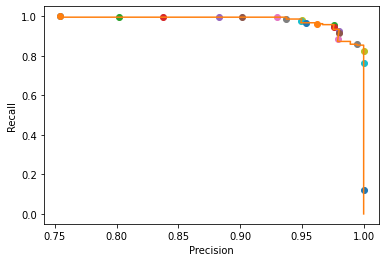

Start: fold 2


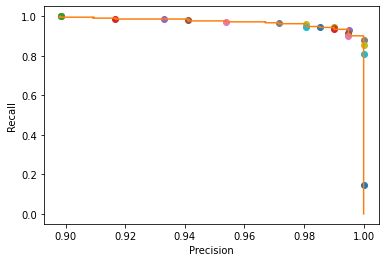

Start: fold 3


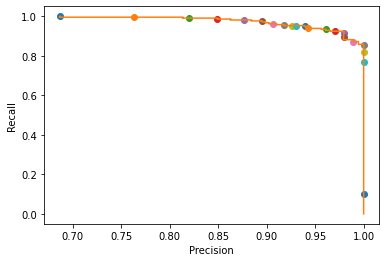

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

# y = df.cls.values
# print(y)
y = df.label.values
accs_dict = {}
elapsed_times_dict = {}
vector_times_dict = {}

def gogo_recall100Sub(X_train, X_test, y_train, y_test, params) -> None:
  START_TIME = time.time()
   
  # for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
  #  print(f'Start: fold {i+1}')
  #  X_train, y_train = X[train_index, :], y[train_index]
  #  X_valid, y_valid = X[valid_index, :], y[valid_index]

  svmclf = svm.SVC(C = 1.0, kernel = 'linear', probability=True)
  # train_docはベクトル化した文書のリスト
  # labelsは文書のカテゴリのリスト
  svmclf.fit(X_train, y_train)
  
  y_pred = svmclf.predict(X_test)
  y_values = svmclf.decision_function(X_test)
  # ad-hoc
  # class 0なら、minus方面、class 1なら plus方面
  cls_idx_dict = {}
  threshhold = params['threshhold']
  print(svmclf.classes_)
  for idx, key in enumerate(svmclf.classes_):
    # cls_idx_dict[key] = idx
    cls_idx_dict[idx] = key

  list1 = []
  for value in y_values:
      if value < threshhold:
        cls = cls_idx_dict[0]
        list1.append(cls)
      else:
        cls = cls_idx_dict[1]
        list1.append(cls)
  
  
  print(classification_report(y_test, y_pred))
  print(" ----- list1 -----")
  print(classification_report(y_test, list1))
  cm = metrics.confusion_matrix(y_test, list1)
  print(cm)
  print()

  elapsed_time = time.time() - START_TIME
  print(f'Elapsed time is {elapsed_time}')
  # return accuracies, elapsed_time


def gogo_recall100(X, y, params) -> None:
  START_TIME = time.time()
  skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
  accuracies = {}
  for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f'Start: fold {i+1}')
    X_train, y_train = X[train_index, :], y[train_index]
    X_test, y_test = X[valid_index, :], y[valid_index]

    #gogo_recall100Sub(X_train, X_test, y_train, y_test, params) -> None:
    gogo_recall100Sub2(X_train, X_test, y_train, y_test, params)

params = {'threshhold': 0.7}

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

def gogo_recall100Sub2(X_train, X_test, y_train, y_test, params) -> None:

  svmclf = svm.SVC(C = 1.0, kernel = 'linear', probability=True)
  # train_docはベクトル化した文書のリスト
  # labelsは文書のカテゴリのリスト
  svmclf.fit(X_train, y_train)
  
  y_pred = svmclf.predict_proba(X_test)

  # ある閾値の時の適合率、再現率の値を取得
  # svmclf = svm.SVC(C = 1.0, kernel = 'linear', probability=True)
  # train_docはベクトル化した文書のリスト
  # labelsは文書のカテゴリのリスト
  svmclf.fit(X_train, y_train)
  
  # ある閾値の時の適合率、再現率の値を取得
  precision, recall, threshold = precision_recall_curve(y_test, svmclf.predict_proba(X_test)[:, 1])
  # 0から1まで0.05刻みで○をプロット
  for i in range(21):
      close_point = np.argmin(np.abs(threshold - (i * 0.05)))
      plt.plot(precision[close_point], recall[close_point], 'o')

  # 適合率-再現率曲線
  plt.plot(precision, recall)
  plt.xlabel('Precision')
  plt.ylabel('Recall')

  plt.show()

vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
START_TIME = time.time()
X = vectorizer.fit_transform(df.wakati_text.values)
X = X.toarray()
vector_time = time.time() - START_TIME
vector_times_dict['bow'] = vector_time

gogo_recall100(X, y, params)

Recall-Precision 曲線を描いておしまい

# LightGBM編

まずは学習データを用いてLightGBMで分類する

1. パラメータチューニングの仕組みを学ぶ
2. スコアを見る
3. PR曲線を描いてみる

In [ ]:
!pip install lightgbm
!pip install optuna
!pip install bayesian-optimization
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.0 MB/s 
     |████████████████████████████████| 209 kB 53.7 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 147 kB 61.5 MB/s 
     |████████████████████████████████| 112 kB 60.5 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=685f11207599556945e3db8f532644813652612cce2e8c2465f373ab3b1c9532
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wh

In [ ]:
!pip install seaborn_analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 2.7 MB/s 
     |████████████████████████████████| 11.2 MB 8.6 MB/s 
     |████████████████████████████████| 2.0 MB 49.1 MB/s 
     |████████████████████████████████| 944 kB 70.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
from sklearn.metrics import precision_recall_curve

def gogo_recall100Sub2(X_train, X_test, y_train, y_test, params) -> None:

  model.set_params(**best_params1)
  # svmclf = svm.SVC(C = 1.0, kernel = 'linear', probability=True)
  # train_docはベクトル化した文書のリスト
  # labelsは文書のカテゴリのリスト
  model.fit(X_train, y_train)
  
  y_pred = svmclf.predict_proba(X_test)

  # ある閾値の時の適合率、再現率の値を取得
  # svmclf = svm.SVC(C = 1.0, kernel = 'linear', probability=True)
  # train_docはベクトル化した文書のリスト
  # labelsは文書のカテゴリのリスト
  svmclf.fit(X_train, y_train)
  
  # ある閾値の時の適合率、再現率の値を取得
  precision, recall, threshold = precision_recall_curve(y_test, svmclf.predict_proba(X_test)[:, 1])
  # 0から1まで0.05刻みで○をプロット
  for i in range(21):
      close_point = np.argmin(np.abs(threshold - (i * 0.05)))
      plt.plot(precision[close_point], recall[close_point], 'o')

  # 適合率-再現率曲線
  plt.plot(precision, recall)
  plt.xlabel('Precision')
  plt.ylabel('Recall')

  plt.show()

vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
START_TIME = time.time()
X = vectorizer.fit_transform(df.wakati_text.values)
X = X.toarray()
vector_time = time.time() - START_TIME
vector_times_dict['bow'] = vector_time

gogo_recall100(X, y, params)

[LightGBM] [Info] Number of positive: 432, number of negative: 853
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 1285, number of used features: 572
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336187 -> initscore=-0.680334
[LightGBM] [Info] Start training from score -0.680334
[1]	valid_0's binary_logloss: 0.594598
[2]	valid_0's binary_logloss: 0.542446
[3]	valid_0's binary_logloss: 0.499177
[4]	valid_0's binary_logloss: 0.463937
[5]	valid_0's binary_logloss: 0.435162
[6]	valid_0's binary_logloss: 0.410426
[7]	valid_0's binary_logloss: 0.386562
[8]	valid_0's binary_logloss: 0.367348
[9]	valid_0's binary_logloss: 0.347256
[10]	valid_0's binary_logloss: 0.332081
[11]	valid_0's binary_logloss: 0.318514
[12]	valid_0

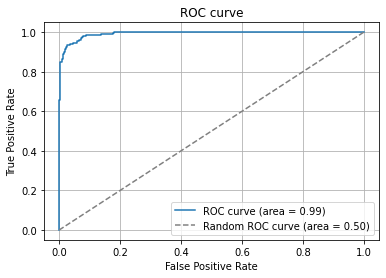

0.9879327880340291


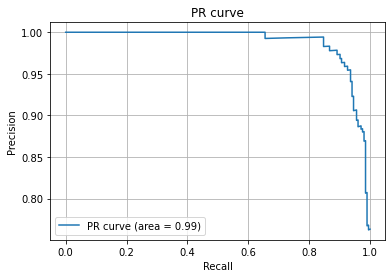

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, random_state = 0)

import lightgbm as lgb
from sklearn.metrics import classification_report

train_data = lgb.Dataset(X_train, label=y_train)
eval_data = lgb.Dataset(X_test, label=y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'random_state':0
    }

gbm = lgb.train(
    params,
    train_data,
    valid_sets=eval_data,
)
y_preds = gbm.predict(X_test)

from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds)
auc = metrics.auc(fpr, tpr)
print(auc)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.plot(np.linspace(1, 0, len(fpr)), np.linspace(1, 0, len(fpr)), label='Random ROC curve (area = %.2f)'%0.5, linestyle = '--', color = 'gray')

plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_preds)

auc = metrics.auc(recall, precision)
print(auc)

plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


In [ ]:
from math import e
# from seaborn_analyzer import regplot
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

import lightgbm as lgb
import pandas as pd
import time

# df_osaka = pd.read_csv(f'./sample_data/osaka_metropolis_english.csv')
OBJECTIVE_VARIALBLE = 'label'  # 目的変数
USE_EXPLANATORY = ['wakati_text']  # 説明変数
y = df[OBJECTIVE_VARIALBLE].values  # 目的変数をndarray化
# X = df[USE_EXPLANATORY].values  # 説明変数をndarray化
# データを表示
# df[USE_EXPLANATORY + [OBJECTIVE_VARIALBLE]]
vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
START_TIME = time.time()
X = vectorizer.fit_transform(df.wakati_text.values)
X = X.toarray()

# 乱数シード
seed = 42
# モデル作成
params1 = { 'boosting_type': 'gbdt', 
              'objective': 'binary',
              'random_state': seed, 
              'n_estimators': 10000 }

# model = lgb.LGBMClassifier(params1)  # チューニング前のモデル
model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary',
                      random_state=seed, n_estimators=10000)
# 学習時fitパラメータ指定
fit_params = {'callbacks': [lgb.early_stopping(
                  stopping_rounds=10, # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
                  verbose=0)],  # 学習中のコマンドライン出力
              'eval_metric': 'recall',  # early_stopping_roundsの評価指標
              'eval_set': [(X, y)]  # early_stopping_roundsの評価指標算出用データ
              }

# クロスバリデーションして決定境界を可視化
cv = KFold(n_splits=3, shuffle=True, random_state=seed) 

from sklearn.model_selection import cross_val_score
# scoring = 'neg_root_mean_squared_error'  # 評価指標をMSEに指定
scoring = 'recall'  # 評価指標をRecallに指定
# クロスバリデーションで評価指標算出
scores = cross_val_score(model, X, y, cv=cv,
                         scoring=scoring, n_jobs=-1, fit_params=fit_params)
print(f'scores={scores}')
print(f'average_score={np.mean(scores)}')


scores=[0.91162791 0.90869565 0.93684211]
average_score=0.9190552214712717


In [ ]:
# !pip install -U matplotlib
!pip uninstall seaborn_analyzer

Found existing installation: seaborn-analyzer 0.2.11
Uninstalling seaborn-analyzer-0.2.11:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/seaborn_analyzer-0.2.11.dist-info/*
    /usr/local/lib/python3.7/dist-packages/seaborn_analyzer/*
Proceed (y/n)? y
  Successfully uninstalled seaborn-analyzer-0.2.11


In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2


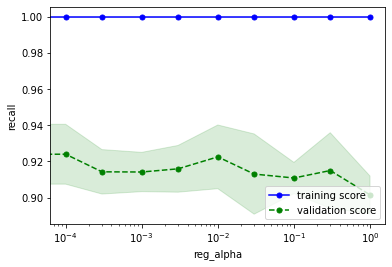

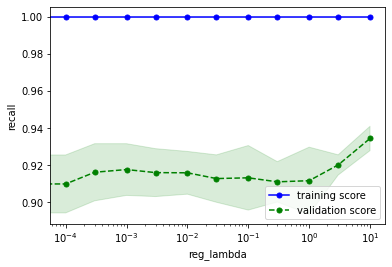

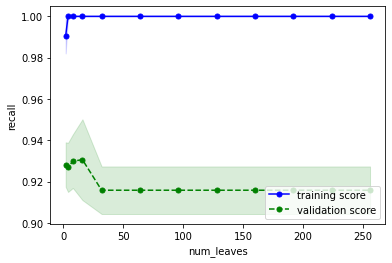

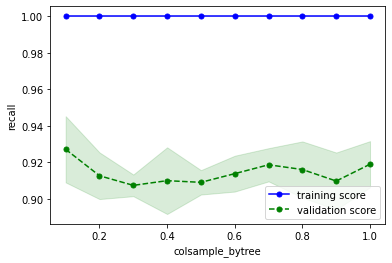

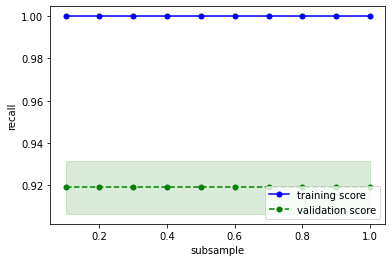

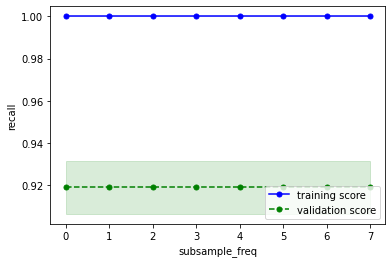

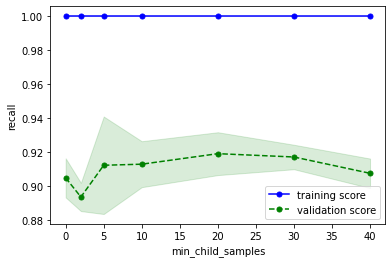

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
cv_params = {'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1],
             'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'num_leaves': [2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 224, 256],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
             'min_child_samples': [0, 2, 5, 10, 20, 30, 40]
             }
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X, y=y,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

In [ ]:
from bayes_opt import BayesianOptimization
start = time.time()
# パラメータ範囲（Tupleで範囲選択）
bayes_params = {'reg_alpha': (0.0001, 1.0),
                'reg_lambda': (0.0001, 0.1),
                'num_leaves': (2, 6),
                'colsample_bytree': (0.4, 1.0),
                'subsample': (0.4, 1.0),
                'subsample_freq': (0, 7),
                'min_child_samples': (0, 10)
                }
# 対数スケールパラメータを対数化
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
bayes_params_log = {k: (np.log10(v[0]), np.log10(v[1])) if param_scales[k] == 'log' else v for k, v in bayes_params.items()}
# 整数型パラメータを指定
int_params = ['num_leaves', 'subsample_freq', 'min_child_samples']

# ベイズ最適化時の評価指標算出メソッド(引数が多いので**kwargsで一括読込)
def bayes_evaluate(**kwargs):
    params = kwargs
    # 対数スケールパラメータは10のべき乗をとる
    params = {k: np.power(10, v) if param_scales[k] == 'log' else v for k, v in params.items()}
    # 整数型パラメータを整数化
    params = {k: round(v) if k in int_params else v for k, v in params.items()}
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
bo = BayesianOptimization(bayes_evaluate, bayes_params_log, random_state=seed)
bo.maximize(init_points=20, n_iter=80, acq='ei')
# 最適パラメータとスコアを取得
best_params = bo.max['params']
best_score = bo.max['target']
# 対数スケールパラメータは10のべき乗をとる
best_params = {k: np.power(10, v) if param_scales[k] == 'log' else v for k, v in best_params.items()}
# 整数型パラメータを整数化
best_params = {k: round(v) if k in int_params else v for k, v in best_params.items()}
# 最適パラメータを表示
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')

|   iter    |  target   | colsam... | min_ch... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.9377   |  0.6247   |  9.507    |  4.928    | -1.605    | -3.532    |  0.4936   |  0.4066   |
|  2        |  0.9308   |  0.9197   |  6.011    |  4.832    | -3.918    | -1.09     |  0.8995   |  1.486    |
|  3        |  0.9171   |  0.5091   |  1.834    |  3.217    | -1.901    | -2.704    |  0.5747   |  4.283    |
|  4        |  0.9211   |  0.4837   |  2.921    |  3.465    | -2.176    | -1.644    |  0.5198   |  3.6      |
|  5        |  0.9252   |  0.7554   |  0.4645   |  4.43     | -3.318    | -3.805    |  0.9693   |  6.759    |
|  6        |  0.9193   |  0.885    |  3.046    |  2.391    | -1.263    | -2.68     |  0.4732   |  3.466    |
|  7        |  0.9265   |  0.4206   |  9.093    |  3.035    | -1.35     | -3.065    |  0.712    |  3.827    |
|  8      

In [ ]:
import optuna
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 10)
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params1 = study.best_trial.params
best_score1 = study.best_trial.value
print(f'最適パラメータ {best_params1}\nスコア {best_score1}')
print(f'所要時間{time.time() - start}秒')

[I 2022-08-06 04:47:59,138] A new study created in memory with name: no-name-8935941e-67b9-401a-962b-65ddad388bab
[I 2022-08-06 04:48:52,131] Trial 0 finished with value: 0.9299097085484186 and parameters: {'reg_alpha': 0.0013292918943162175, 'reg_lambda': 0.07114476009343425, 'num_leaves': 5, 'colsample_bytree': 0.759195090518222, 'subsample': 0.4936111842654619, 'subsample_freq': 1, 'min_child_samples': 0}. Best is trial 0 with value: 0.9299097085484186.
[I 2022-08-06 04:49:05,812] Trial 1 finished with value: 0.9235023858939563 and parameters: {'reg_alpha': 0.0396760507705299, 'reg_lambda': 0.006358358856676255, 'num_leaves': 5, 'colsample_bytree': 0.41235069657748147, 'subsample': 0.9819459112971965, 'subsample_freq': 6, 'min_child_samples': 2}. Best is trial 0 with value: 0.9299097085484186.
[I 2022-08-06 04:49:14,623] Trial 2 finished with value: 0.9279513242154932 and parameters: {'reg_alpha': 0.0003511356313970409, 'reg_lambda': 0.0003549878832196505, 'num_leaves': 3, 'colsampl

最適パラメータ {'reg_alpha': 0.0001250632120846817, 'reg_lambda': 0.0046568741317746685, 'num_leaves': 3, 'colsample_bytree': 0.458652427983427, 'subsample': 0.6860595105351172, 'subsample_freq': 0, 'min_child_samples': 10}
スコア 0.947272630514608
所要時間2325.302092552185秒


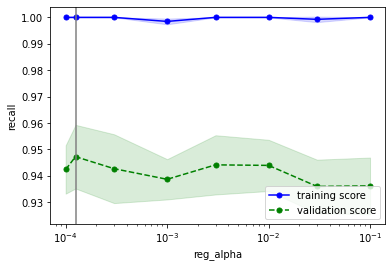

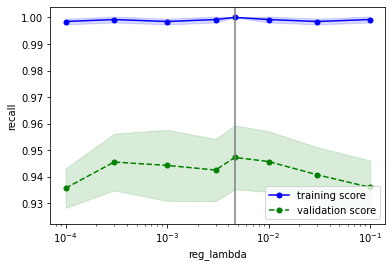

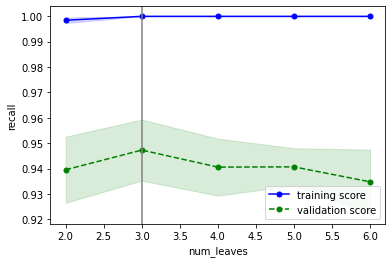

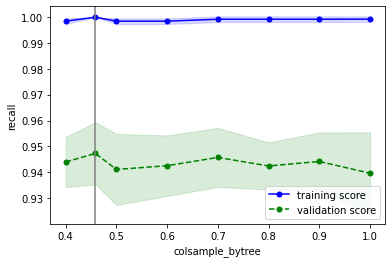

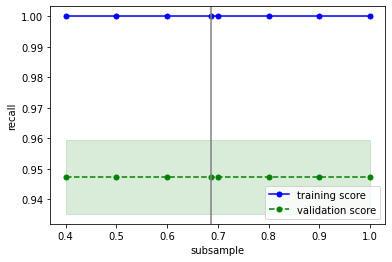

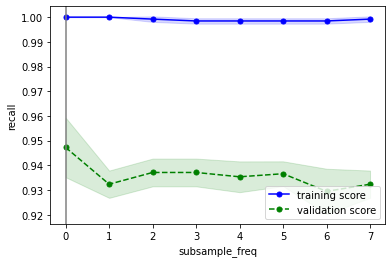

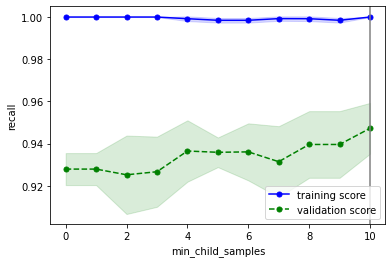

In [ ]:
from sklearn.model_selection import validation_curve
# 検証曲線描画対象パラメータ
valid_curve_params = {'reg_alpha': [0.00001, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1],
                      'reg_lambda': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1],
                      'num_leaves': [2, 3, 4, 5, 6],
                      'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                      'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                      'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
                      'min_child_samples': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                      }
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
# 最適パラメータを上記描画対象に追加
for k, v in valid_curve_params.items():
    if best_params[k] not in v:
        v.append(best_params[k])
        v.sort()
for i, (k, v) in enumerate(valid_curve_params.items()):
    # モデルに最適パラメータを適用
    model.set_params(**best_params)
    # 検証曲線を描画
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X, y=y,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # 最適パラメータを縦線表示
    plt.axvline(x=best_params[k], color='gray')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

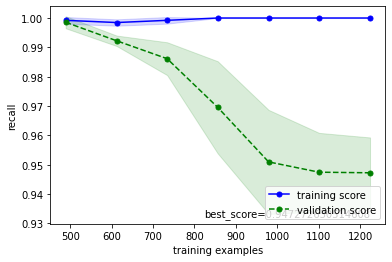

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# 最適パラメータを学習器にセット
model.set_params(**best_params1)

# 学習曲線の取得
train_sizes, train_scores, valid_scores = learning_curve(estimator=model,
                                                         X=X, y=y,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         fit_params=fit_params,
                                                         cv=cv, scoring=scoring, n_jobs=-1)
# 学習データ指標の平均±標準偏差を計算
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
train_center = train_mean
train_high = train_mean + train_std
train_low = train_mean - train_std
# 検証データ指標の平均±標準偏差を計算
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
valid_center = valid_mean
valid_high = valid_mean + valid_std
valid_low = valid_mean - valid_std
# training_scoresをプロット
plt.plot(train_sizes, train_center, color='blue', marker='o', markersize=5, label='training score')
plt.fill_between(train_sizes, train_high, train_low, alpha=0.15, color='blue')
# validation_scoresをプロット
plt.plot(train_sizes, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
plt.fill_between(train_sizes, valid_high, valid_low, alpha=0.15, color='green')
# 最高スコアの表示
best_score = valid_center[len(valid_center) - 1]
plt.text(np.amax(train_sizes), valid_low[len(valid_low) - 1], f'best_score={best_score}',
                color='black', verticalalignment='top', horizontalalignment='right')
# 軸ラベルおよび凡例の指定
plt.xlabel('training examples')  # 学習サンプル数を横軸ラベルに
plt.ylabel(scoring)  # スコア名を縦軸ラベルに
plt.legend(loc='lower right')  # 凡例

テスト。

In [ ]:
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# y = df.cls.values
y = df.label.values
print(y)
accs_dict = {}
elapsed_times_dict = {}
vector_times_dict = {}

def search_parametor_lightgbm(X, y, params) -> None:
  START_TIME = time.time()
  skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
  accuracies = {}
  for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f'Start: fold {i+1}')
    X_train, y_train = X[train_index, :], y[train_index]
    X_valid, y_valid = X[valid_index, :], y[valid_index]

    svmclf = svm.SVC(C = 1.0, kernel = 'linear')
    # train_docはベクトル化した文書のリスト
    # labelsは文書のカテゴリのリスト
    svmclf.fit(X_train, y_train)
    y_pred = svmclf.predict(X_valid)

    # print(y_pred)

    accuracy = metrics.accuracy_score(y_valid, y_pred)
    cm = metrics.confusion_matrix(y_valid, y_pred)



[ 1  1  1 ... -1 -1 -1]
